<a href="https://colab.research.google.com/github/buchijw/Long_ML_Course/blob/main/6_Molecular_Representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit-pypi tdqm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
url = 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4932683/table/Tab1/?report=objectonly'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools
import IPython
from tqdm.auto import tqdm
tqdm.pandas()
df = pd.read_csv("/content/drive/MyDrive/MedAI/1. Chemoinformatics/Data/EGFR_compounds_lipinski.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(f"Number of molecules in dataset: {len(df)}")
df = df.iloc[:100,:]
print(f"Number of molecules in dataset: {len(df)}")

Number of molecules in dataset: 4635
Number of molecules in dataset: 100


# **Standardization**

In [ ]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs
from rdkit import Chem, DataStructs
def standardize(smiles):
        # Code borrowed from https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/
        # follows the steps in
        # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
        # as described **excellently** (by Greg) in
        # https://www.youtube.com/watch?v=eWTApNX8dJQ
      mol = Chem.MolFromSmiles(smiles)

        # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
      clean_mol = rdMolStandardize.Cleanup(mol) 

        # if many fragments, get the "parent" (the actual mol we are interested in) 
      parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

        # try to neutralize molecule
      uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
      uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

        # note that no attempt is made at reionization at this step
        # nor at ionization at some pH (rdkit has no pKa caculator)
        # the main aim to to represent all molecules from different sources
        # in a (single) standard way, for use in ML, catalogue, etc.

      te = rdMolStandardize.TautomerEnumerator() # idem
      taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)

      return taut_uncharged_parent_clean_mol

In [ ]:
block = BlockLogs()
df['Molecule'] = df['smiles'].progress_apply(standardize)

  0%|          | 0/100 [00:00<?, ?it/s]

# **1. Molecular descriptors**

Similarity can be assessed in many different ways depending on the application (see [<i>J. Med. Chem.</i> (2014), <b>57</b>, 3186-3204</a>](http://pubs.acs.org/doi/abs/10.1021/jm401411z)): 

- 1D molecular descriptor: Solubility, logP, molecular weight, melting point.
  - Global descriptor: only one value represents the whole molecule
  - Usually do not contain enough information to be applied to machine learning (ML)
  - Can be added to 2D fingerprints to improve molecular encoding for ML
- 2D molecular descriptors: Molecular graphs, paths, fragments, atom environments
  - Detailed representation of individual parts of the molecule
  - Contains many features/bits per molecule called fingerprints
  - Very often used in similarity search and ML
- 3D molecular descriptors: Shape, stereochemistry
  - Less robust than 2D representations because of molecule flexibility (what is the "right" conformation of a molecule?)
    Biological similarity
  - Biological fingerprint, e.g. individual bits represent bioactivity measure against different targets
  - Independent of molecular structure
  - Requires experimental (or predicted) data

We already learned how to calculate 1D physicochemical parameters, such as the molecular weight and logP in **Talktorial T002**. 
More information about these [descriptors](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors) in the `rdkit` documentation.  

In the following, we focus on the definition of 2D molecular descriptors. Due to their, mostly, uniqueness per molecule, these descriptors are also called fingerprints.

## 1.1 RDKit descriptors

  0%|          | 0/100 [00:00<?, ?it/s]

,molecule_chembl_id,smiles,pIC50,Molecule,0,1,2,3,4,5,...,198,199,200,201,202,203,204,205,206,207
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,4.401118,0.813753,4.401118,0.813753,0.499383,350.219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,5.706147,0.563160,5.706147,0.563160,0.648824,388.265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

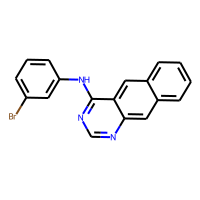
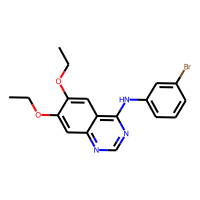

In [ ]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors


def mol2rdkit(mol):
  des_list = [x[0] for x in Descriptors._descList]
  calculator = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
  d = calculator.CalcDescriptors(mol)
  return d


df["RDK"] = df.Molecule.progress_apply(mol2rdkit)
X = np.stack(df.RDK.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["RDK"], axis =1)
df.head(2)

In [ ]:
df["maccs"] = df.Molecule.progress_apply(mol2maccs)
X = np.stack(df.maccs.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["maccs"], axis =1)
df.head(2)

## 1.2. Mordred descriptors

In [ ]:
!pip install mordred

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 128 kB 4.2 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176725 sha256=6a730e548d9c8ec93f4ea09d13db46ae124ae01a530032385e6d5a4faccf2bbd
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred


In [ ]:
# 2D mordred
calc = Calculator(descriptors, ignore_3D=True)
df_2d_mordred = calc.pandas(mord.Molecule)
df_2d_mordred = pd.concat([mord['pIC50'], df_2d_mordred], axis = 1)
df_2d_mordred.head(5)

100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


,pIC50,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,11.522879,17.665739,12.986491,0,0,29.423733,2.455860,4.911721,29.423733,1.337442,...,10.099507,56.487008,349.021459,10.265337,1046,35,120.0,142.0,5.277778,4.750000
1,11.221849,18.372846,14.479004,0,0,30.892599,2.445084,4.890168,30.892599,1.287192,...,10.045985,58.424931,387.058239,9.215672,1357,37,122.0,142.0,7.277778,5.500000
2,11.221849,16.470305,13.003112,0,0,26.963354,2.421019,4.842038,26.963354,1.283969,...,9.946403,54.931982,343.043258,9.801236,930,32,110.0,128.0,6.527778,4.583333
3,11.096910,16.958632,13.215720,0,0,27.969699,2.464774,4.893134,27.969699,1.331890,...,10.047977,68.855659,339.011957,10.935870,915,32,116.0,138.0,5.027778,4.500000
4,11.096910,15.584859,12.311289,0,0,26.203635,2.411735,4.823470,26.203635,1.310182,...,9.878426,53.629921,329.027607,10.282113,815,30,104.0,121.0,5.666667,4.472222


In [ ]:
# 3D mordred
from mordred import Calculator, descriptors
mord = df.copy()
calc = Calculator(descriptors, ignore_3D=False)
df_3d_mordred = calc.pandas(mord.Molecule)
df_3d_mordred = pd.concat([mord['pIC50'], df_3d_mordred], axis = 1)
df_3d_mordred.head(5)

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


,pIC50,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,11.522879,17.665739,12.986491,0,0,29.423733,2.455860,4.911721,29.423733,1.337442,...,10.099507,56.487008,349.021459,10.265337,1046,35,120.0,142.0,5.277778,4.750000
1,11.221849,18.372846,14.479004,0,0,30.892599,2.445084,4.890168,30.892599,1.287192,...,10.045985,58.424931,387.058239,9.215672,1357,37,122.0,142.0,7.277778,5.500000
2,11.221849,16.470305,13.003112,0,0,26.963354,2.421019,4.842038,26.963354,1.283969,...,9.946403,54.931982,343.043258,9.801236,930,32,110.0,128.0,6.527778,4.583333
3,11.096910,16.958632,13.215720,0,0,27.969699,2.464774,4.893134,27.969699,1.331890,...,10.047977,68.855659,339.011957,10.935870,915,32,116.0,138.0,5.027778,4.500000
4,11.096910,15.584859,12.311289,0,0,26.203635,2.411735,4.823470,26.203635,1.310182,...,9.878426,53.629921,329.027607,10.282113,815,30,104.0,121.0,5.666667,4.472222


# **2. Molecular fingerprints**

Molecular fingerprints are a computational representation of molecules that encode chemical and molecular features in the form of bitstrings, bitvectors or arrays. Each bit corresponds to a predefined molecular feature or environment, where "1" represents the presence and "0" the absence of a feature. Note that some implementations are count-based. Thus, they count how often a specific feature is present.

There are multiple ways to design fingerprints.
Here, we introduce MACCS keys and Morgan fingerprint as two commonly used 2D fingerprints. 
As can be seen in the `rdkit` documentation on [fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints), `rdkit` also offers multiple alternate fingerprints. 

The fingerprints may be classified as follows. Additional details are in the publication by Riniker and Landrum:

- Path-based fingerprints RDKx where x is 5, 6, 7 (hashed branched and linear subgraphs up to size x), TT (topological torsion [[26](https://pubs.acs.org/doi/abs/10.1021/ci00054a008)], a count vector) and a binary vector form HashTT, AP [[[27](https://pubs.acs.org/doi/abs/10.1021/ci00046a002)] (atom pair, a count vector) and a binary vector form HashAP.
- Substructure keys Avalon [[28](https://pubs.acs.org/doi/10.1021/ci050413p)], MACCS.
- Circular fingerprints The extended-connectivity fingerprints [[29](https://pubs.acs.org/doi/10.1021/ci100050t)] ECFPx where x is 0, 2, 4, 6, and the corresponding count vectors denoted as ECFCx. Also the feature-class fingerprints FCFPx and corresponding count vectors FCFCx where x is 2, 4, 6.
- Pharmacophore fingerprint: [[Cats2d]()]
- MinHashed Atom Pair fingerprint of radius 2 [[MAP4](https://github.com/reymond-group/map4)]

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4932683/table/Tab1/?report=objectonly

In [ ]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys, AllChem
from rdkit.Avalon import pyAvalonTools as fpAvalon
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.ChemicalFeatures import BuildFeatureFactory
from rdkit.Chem import rdMolDescriptors

## 2.1. Dictionary-based fingerprint


### 2.1.1. MACCS fingerprints

Molecular ACCess System 
(MACCS) fingerprints, also termed MACCS structural keys, consist of 166 predefined structural fragments. Each position queries the presence or absence of one particular structural fragment or key. 
The individual keys were empirically defined by medicinal chemists and are simple to use and interpret (`rdkit` documentation on [MACCS keys](http://rdkit.org/Python_Docs/rdkit.Chem.MACCSkeys-module.html)).

  0%|          | 0/4635 [00:00<?, ?it/s]

,molecule_chembl_id,smiles,pIC50,Molecule,0,1,2,3,4,5,...,157,158,159,160,161,162,163,164,165,166
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0

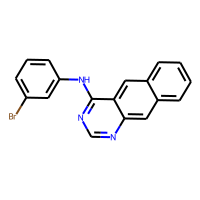
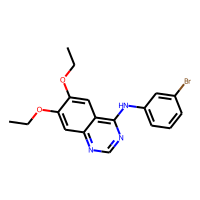

In [ ]:
from rdkit.Chem import MACCSkeys
from rdkit import Chem, DataStructs

# Function to MACCS Fingerprint 167 bit
def mol2maccs(mol):
    fp = MACCSkeys.GenMACCSKeys(mol) # rdkit.DataStructs => convert to np
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["maccs"] = df.Molecule.progress_apply(mol2maccs)
X = np.stack(df.maccs.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["maccs"], axis =1)
df.head(2)

### 2.1.2. Avalon 

fpdict['avalon'] = lambda m: fpAvalon.GetAvalonFP(m, nbits)
fpdict['laval'] = lambda m: fpAvalon.GetAvalonFP(m, longbits)

  0%|          | 0/4635 [00:00<?, ?it/s]

,molecule_chembl_id,smiles,pIC50,Molecule,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,0,0,1,0,0,0,...,1,0,1,1,0,0,0,0,0,0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,0,0,1,0,0,0,...,1,0,1,1,0,0,0,0,0,0

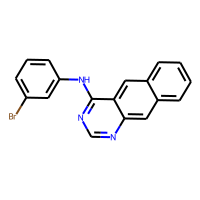
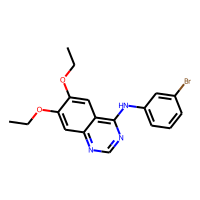

In [ ]:
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to avalon Fingerprint 1024 bit
def mol2Avalon(mol):
    fp = fpAvalon.GetAvalonFP(mol, 1024) # rdkit.DataStructs => convert to np
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["Avalon"] = df.Molecule.progress_apply(mol2Avalon)
X = np.stack(df.Avalon.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["Avalon"], axis =1)
df.head(2)

  0%|          | 0/100 [00:00<?, ?it/s]

,molecule_chembl_id,smiles,pIC50,Molecule,0,1,2,3,4,5,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

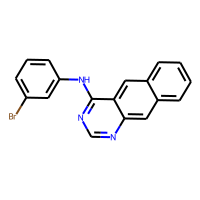
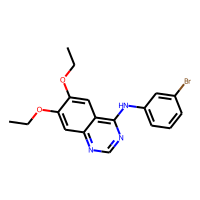

In [ ]:
# 16384-bit form of Avalon
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to avalon Fingerprint 16384 bit
def mol2Avalon(mol):
    fp = fpAvalon.GetAvalonFP(mol, 16384) # rdkit.DataStructs => convert to np
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["laval"] = df.Molecule.progress_apply(mol2Avalon)
X = np.stack(df.laval.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["laval"], axis =1)
df.head(2)

### 2.1.3. PubChem

In [ ]:
#installing the library
!pip install padelpy
#Downloading the XML data files
!wget https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
!unzip fingerprints_xml.zip
#listing and sorting the downloaded files
import glob
xml_files = glob.glob("*.xml")
xml_files.sort()
xml_files
#Creating a list of present files
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

#Creating Data Dictionary
fp = dict(zip(FP_list, xml_files))
fp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 1.3 MB/s 
--2022-08-13 07:55:28--  https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip [following]
--2022-08-13 07:55:29--  https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10871 (11K) [application/zip]
Saving to: ‘fingerprints_xml.zip’

fingerprints_xml.zi 100%[

{'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDKgraphonly': 'GraphOnlyFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'PubChem': 'PubchemFingerprinter.xml',
 'Substructure': 'SubstructureFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml'}

In [ ]:
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
df['smiles'].to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
#Setting the fingerprint module

from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule.smi', 
                d_file=fingerprint_output_file, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)
data_fp = pd.read_csv(fingerprint_output_file)
data_fp.head(2)

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_molecule_2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for i, j in enumerate(data_fp['Name']):
  data_fp['Name'][i] = j.replace("AUTOGEN_molecule_", "")
data_fp['Name'] = data_fp['Name'].astype('int')
data_fp.sort_values(by='Name', inplace = True)
data_fp.reset_index(inplace = True, drop = True)
pubchem = pd.concat([df['pIC50'], data_fp], axis = 1)

pubchem.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pIC50,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,11.522879,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.221849,2,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.221849,3,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.096910,4,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.096910,5,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.2. Morgan fingerprints and circular fingerprints 

This family of fingerprints is based on the Morgan algorithm. 
The bits correspond to the circular environments of each atom in a molecule. 
The number of neighboring bonds and atoms to consider is set by the radius. 
Also the length of the bit string can be defined, a longer bit string will be modded to the desired length. 
Therefore, the Morgan fingerprint is not limited to a certain number of bits. 
More about the [Morgan fingerprint](http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints) can be found in the 
`rdkit` documentation. 
Extended connectivity fingerprints (ECFP) are also commonly used fingerprints that are derived using a variant of the Morgan algorithm, see [<i>J. Chem. Inf. Model.</i> (2010), <b>50</b>,742-754](https://pubs.acs.org/doi/abs/10.1021/ci100050t) for further information. 


### 2.2.1. Extended connectivity fingerprints (ECFP)

- r = 0 => ECFP0
- r = 1 => ECFP2
- r = 2 => ECFP4
- r = 3 => ECFP6


  0%|          | 0/100 [00:00<?, ?it/s]

,molecule_chembl_id,smiles,pIC50,Molecule,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

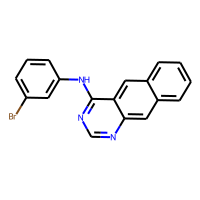
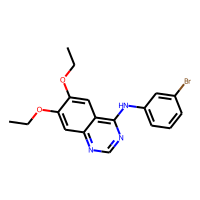

In [ ]:
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to ECFP 1024 bit
def mol2fp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 0, nBits=1024) # rdkit.DataStructs => convert to np
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["ecfp0"] = df.Molecule.progress_apply(mol2fp)
X = np.stack(df.ecfp0.values)
X_df = pd.DataFrame(X)
df2 = pd.concat([df, X_df], axis = 1).drop(["ecfp0"], axis =1)
df2.head(2)

### 2.2.2. Count vector form of ECFP (ECFC)

- r = 0 => ECFC0
- r = 1 => ECFC2
- r = 2 => ECFC4
- r = 3 => ECFC6

In [ ]:
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to ECFP 1024 bit
def mol2ecfc(mol):
    fp = AllChem.GetMorganFingerprint(mol, 0) # rdkit.DataStructs => convert to np
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["ecfc0"] = df.Molecule.progress_apply(mol2ecfc)
X = np.stack(df.ecfc0.values)
X_df = pd.DataFrame(X)
df2 = pd.concat([df, X_df], axis = 1).drop(["ecfc0"], axis =1)
df2.head(2)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### 2.2.3. Feature-class fingerprint (FCFP)

  0%|          | 0/100 [00:00<?, ?it/s]

,molecule_chembl_id,smiles,pIC50,Molecule,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0

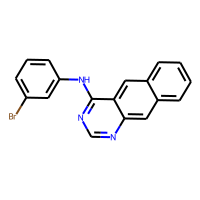
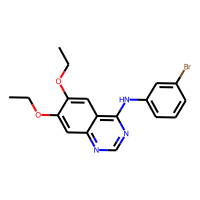

In [ ]:
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to FCFP 1024 bit
def mol2fcfp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 1, useFeatures=True, nBits=1024) 
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["fcfp2"] = df.Molecule.progress_apply(mol2fcfp)
X = np.stack(df.fcfp2.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["fcfp2"], axis =1)
df.head(2)

### 2.2.4. Count vector form of FCFP (FCFC)

In [ ]:
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to FCFC 1024 bit
def mol2fcfc(mol):
    fp = AllChem.GetMorganFingerprint(mol, 1, useFeatures=True)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["fcfc2"] = df.Molecule.progress_apply(mol2fcfc)
X = np.stack(df.fcfc2.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["fcfc2"], axis =1)
df.head(2)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### 2.2.5. LECFP-16384-bit form of ECFP4 and ECP6

In [ ]:
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to FCFC 1024 bit
def mol2lecfp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=longbits)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["LECFP4"] = df.Molecule.progress_apply(mol2lecfp)
X = np.stack(df.LECFP4.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["LECFP4"], axis =1)
df.head(2)

### 2.2.6. LFCFP-16384-bit form of FCFP4 and ECP6


In [ ]:
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to FCFC 1024 bit
def mol2lfcfp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2,useFeatures=True, nBits=longbits)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["LFCFP4"] = df.Molecule.progress_apply(mol2lfcfp)
X = np.stack(df.LFCFP4.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["LFCFP4"], axis =1)
df.head(2)

## **2.3. Pathway fingerprint**

### 2.3.1. Atom pair fingerprint(AP)

In [ ]:
from rdkit.Chem.AtomPairs import Pairs, Torsions
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to Atom pair 1024 bit
def mol2ap(mol):
    fp = Pairs.GetAtomPairFingerprint(mol) # rdkit.DataStructs => convert to np
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["AP"] = df.Molecule.progress_apply(mol2ap)
X = np.stack(df.AP.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["AP"], axis =1)
df.head(2)

  0%|          | 0/100 [00:00<?, ?it/s]

,molecule_chembl_id,smiles,pIC50,Molecule,0,1,2,3,4,5,...,8388598,8388599,8388600,8388601,8388602,8388603,8388604,8388605,8388606,8388607
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,"<img data-content=""rdkit/molecule"" src=""data:i...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,"<img data-content=""rdkit/molecule"" src=""data:i...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Function to HASAP Fingerprint 
def mol2hasap(mol):
    fp = Pairs.GetAtomPairFingerprint(mol) # rdkit.DataStructs => convert to np
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["HASAP"] = df.Molecule.progress_apply(mol2hasap)
X = np.stack(df.HASAP.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["HASAP"], axis =1)
df.head(2)

  0%|          | 0/100 [00:00<?, ?it/s]

,molecule_chembl_id,smiles,pIC50,Molecule,0,1,2,3,4,5,...,8388598,8388599,8388600,8388601,8388602,8388603,8388604,8388605,8388606,8388607
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,"<img data-content=""rdkit/molecule"" src=""data:i...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,"<img data-content=""rdkit/molecule"" src=""data:i...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3.2. Topological torsion fingerprint

In [ ]:
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to torsion Fingerprint 
def mol2torsion(mol):
    fp = Torsions.GetTopologicalTorsionFingerprintAsIntVect(mol) 
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["tt"] = df.Molecule.progress_apply(mol2torsion)
X = np.stack(df.tt.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["tt"], axis =1)
df.head(2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Function to hash torsion Fingerprint 
def mol2hashtorsion(mol):
    fp = Torsions.GetTopologicalTorsionFingerprintAsIntVect(mol, nBits = 1024) 
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["hashtt"] = df.Molecule.progress_apply(mol2to)
X = np.stack(df.hashtt.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["hashtt"], axis =1)
df.head(2)

### 2.3.3. RDK encodes paths of maximum length (RDK)

- maxPath=5 => RDK5
- maxPath=6 => RDK6
- maxPath=7 => RDK7

In [ ]:
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
# Function to hash torsion Fingerprint 
def mol2rdk(mol):
    fp = Chem.RDKFingerprint(mol, maxPath=5, fpSize=2024, nBitsPerHash=2)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
df["rdk5"] = df.Molecule.progress_apply(mol2rdk)
X = np.stack(df.rdk5.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["rdk5"], axis =1)
df.head(2)

  0%|          | 0/100 [00:00<?, ?it/s]

,molecule_chembl_id,smiles,pIC50,Molecule,0,1,2,3,4,5,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,"<img data-content=""rdkit/molecule"" src=""data:i...",0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,"<img data-content=""rdkit/molecule"" src=""data:i...",0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 2.4. Pharmacophore fingerprint - CATS2D 



In [ ]:
!git clone https://github.com/iwatobipen/CATS2D.git
import os
os.chdir('/content/CATS2D')
!pip install -e .

In [ ]:
# Function to hash pharmacophore Fingerprint 
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
def mol2cats(mol):
  cats = CATS2D(max_path_len=9)
  fp = cats.getCATs2D(mol)
  ar = np.array(fp)

  #DataStructs.ConvertToNumpyArray(fp, ar)
  return ar
     
df["cats2d"] = df.Molecule.progress_apply(mol2cats)
X = np.stack(df.cats2d.values)
X_df = pd.DataFrame(X)
df = pd.concat([df, X_df], axis = 1).drop(["cats2d"], axis =1)
df.head(2)

  0%|          | 0/100 [00:00<?, ?it/s]

,molecule_chembl_id,smiles,pIC50,Molecule,0,1,2,3,4,5,...,200,201,202,203,204,205,206,207,208,209
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,"<img data-content=""rdkit/molecule"" src=""data:i...",1,0,0,0,0,0,...,20,44,58,56,46,48,44,34,24,16
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,"<img data-content=""rdkit/molecule"" src=""data:i...",1,0,0,0,0,0,...,16,34,42,38,30,32,30,22,10,2


## 2.4. Map4 fingerprint

In [ ]:
!pip install git+https://github.com/reymond-group/map4@v1.0 tmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/reymond-group/map4 (to revision v1.0) to /tmp/pip-req-build-ujgj7y1x
  Running command git clone -q https://github.com/reymond-group/map4 /tmp/pip-req-build-ujgj7y1x
  Running command git checkout -q 1457602793f0438a77ee9578ef89ab9a20840c00
     |████████████████████████████████| 494 kB 4.3 MB/s 
     |████████████████████████████████| 1.7 MB 57.1 MB/s 
     |████████████████████████████████| 88 kB 6.7 MB/s 
     |████████████████████████████████| 1.1 MB 43.5 MB/s 
  Created wheel for tmap: filename=tmap-1.2.1-py3-none-any.whl size=546592 sha256=4c1b72a258845a7848f93ec824d14f12b84bdd31bce3a1bb3419fb37f9f1dd2f
  Stored in directory: /root/.cache/pip/wheels/53/7f/1d/2adaaa3f4645010dd23926c4b995cdc5c84eb6489d728eb18f
  Created wheel for networkx: filename=networkx-2.2-py2.py3-none-any.whl size=1526923 sha256=b678be74c989ffcb24567e1f7bcada24e6754d6e6ab421666cdd416

,molecule_chembl_id,smiles,pIC50,Molecule,map4,0,1,2,3,4,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...",0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,,"[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, ...",1,1,0,0,0,...,0,1,0,1,0,1,1,0,0,1
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, ...",0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,,"[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, ...",0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, ...",0,0,0,0,0,...,1,1,0,1,0,0,1,0,0,1

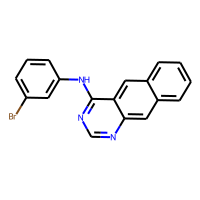
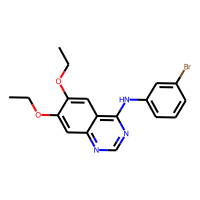
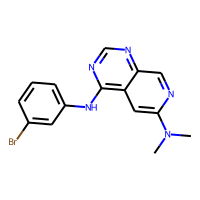
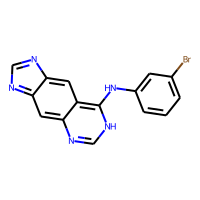
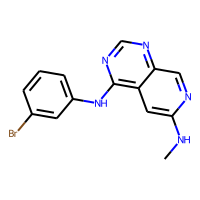

In [ ]:
from map4 import MAP4Calculator
df = df[['molecule_chembl_id', 'smiles', 'pIC50','Molecule']]
map4 = df.copy()
m4_calc = MAP4Calculator(is_folded=True)
map4['map4'] = [m4_calc.calculate(x) for x in map4.Molecule]
X = np.stack(map4.map4.values)
data = pd.DataFrame(X)
map4= pd.concat([map4, data], axis = 1)
map4.head(5)

# **3. Mol2vec**

In [ ]:
!git clone https://github.com/samoturk/mol2vec.git
!pip install git+https://github.com/samoturk/mol2vec

fatal: destination path 'mol2vec' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-sedz54xu
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-sedz54xu


In [ ]:
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from gensim.models import word2vec
from mol2vec import features
from mol2vec import helpers

mol2vec =df.copy()
model = word2vec.Word2Vec.load('mol2vec/examples/models/model_300dim.pkl')
mol2vec['sentence'] = mol2vec.progress_apply(lambda x: MolSentence(mol2alt_sentence(x['Molecule'], 1)), axis=1)
mol2vec['mol2vec'] = [DfVec(x) for x in sentences2vec(mol2vec['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in mol2vec['mol2vec']])
        #y = np.array(self.data['pChEMBL Value'].astype(float))
mol2vec = pd.concat([mol2vec[['pIC50']], pd.DataFrame(X)], axis = 1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
mol2vec.head(5)

,pIC50,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,11.522879,2.485529,-2.922471,-3.717085,10.550318,-0.801327,1.326889,-10.985056,0.356976,6.462907,...,-0.801941,9.634027,11.647388,-0.716247,-5.107119,-3.443156,-5.174129,-3.290773,-9.176306,-1.107343
1,11.221849,2.240366,-2.601800,-3.733226,9.176834,2.166348,1.398619,-10.865446,-0.818757,5.126223,...,-0.185332,9.028879,10.955435,-1.704661,-5.842333,-4.272046,-5.718244,-5.373875,-9.947449,-4.330626
2,11.221849,3.381756,-2.357153,-2.652858,7.669802,1.407446,0.903148,-9.297071,1.266396,4.341089,...,-0.246087,7.714623,10.304363,-0.791477,-6.264503,-2.860437,-5.603094,-3.633482,-10.561360,-2.066326
3,11.096910,3.750911,-3.467593,-3.677412,8.790550,-0.404417,1.073294,-9.490381,-0.351246,4.575303,...,-1.160217,8.801172,11.476744,-1.564389,-3.988413,-3.471590,-5.243902,-3.584324,-9.542894,-2.277698
4,11.096910,3.932242,-3.197761,-3.245634,8.865363,0.922412,1.608174,-9.979620,-0.506348,4.675114,...,0.173380,7.262876,10.676299,-0.738816,-5.403689,-2.390484,-5.452064,-3.923766,-8.442237,-1.596937
